# Image Enhancement using Retinex Algorithms

## Import Library

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt

## Single-Scale Retinex

In [2]:
def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

## Multi Scale Retinex

In [3]:
def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)


    return msr

## Multi Scale Retinex with Color Restoration

In [4]:
def color_balance(img, low_per, high_per):
    '''Contrast stretch img by histogram equilization with black and white cap'''

    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)

    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li
                        else (255 if i > hi else round((i - li) / (hi - li) * 255))
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)

    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None

def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=1):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels

    img = img.astype(np.float64) + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr = G * (msr_img*crf - b)
    # normalize MSRCR
    msrcr = cv2.normalize(msrcr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr = color_balance(msrcr, low_per, high_per)

    return msrcr

## Multi Scale Retinex with Color Preservation

In [5]:
def msrcp(img, sigma_scales=[15, 80, 250], low_per=1, high_per=1):
    # Multi-scale retinex with Color Preservation
    # Int(x,y) = sum(Ic(x,y))/3, c={0...k-1}, k=no.of channels
    # MSR_Int(x,y) = MSR(Int(x,y)), and apply color balance
    # B(x,y) = MAX_VALUE/max(Ic(x,y))
    # A(x,y) = max(B(x,y), MSR_Int(x,y)/Int(x,y))
    # MSRCP = A*I

    # Intensity image (Int)
    int_img = (np.sum(img, axis=2) / img.shape[2]) + 1.0
    # Multi-scale retinex of intensity image (MSR)
    msr_int = msr(int_img, sigma_scales)
    # color balance of MSR
    msr_cb = color_balance(msr_int, low_per, high_per)

    # B = MAX/max(Ic)
    B = 256.0 / (np.max(img, axis=2) + 1.0)
    # BB = stack(B, MSR/Int)
    BB = np.array([B, msr_cb/int_img])
    # A = min(BB)
    A = np.min(BB, axis=0)
    # MSRCP = A*I
    msrcp = np.clip(np.expand_dims(A, 2) * img, 0.0, 255.0)

    return msrcp.astype(np.uint8)


## IMPLEMENTASI

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11876\3863316315.py:26: RuntimeWarning: divide by zero encountered in log10
  return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)


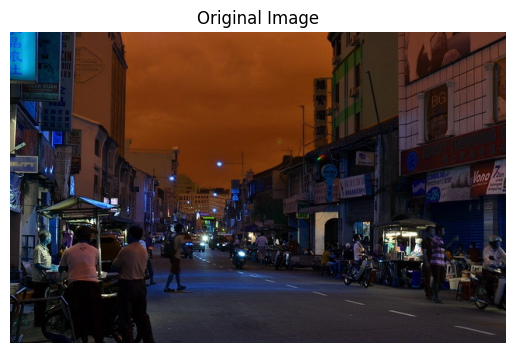

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9344984512435677..1.2301587409443187].


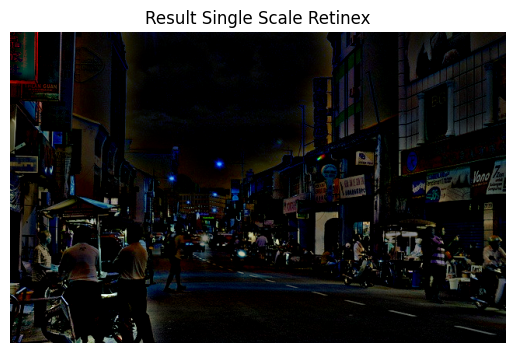

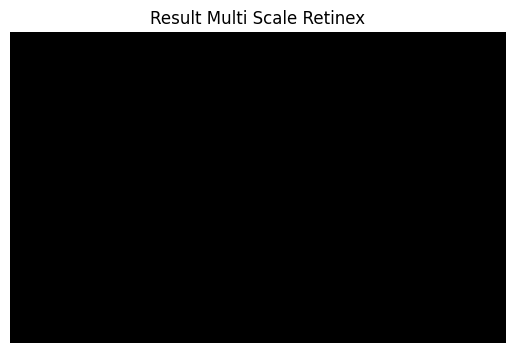

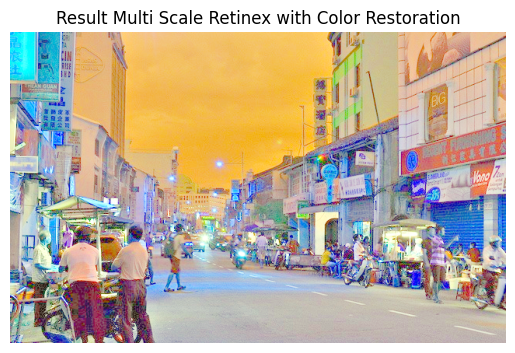

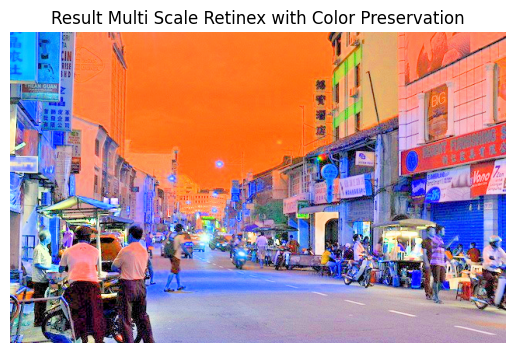

In [ ]:
path = "./data1.jpg"
img_src = cv2.imread(path)
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)

# Implementation Process Image
img_ssr = ssr(img_src, 15)
img_msr = msr(img_src)
img_msrcr = msrcr(img_src)
img_msrcp = msrcp(img_src)


# Display the image using matplotlib
plt.imshow(img_src)
plt.title("Original Image")
plt.axis("off")  # Hide axes for better visualization
plt.show()

plt.imshow(img_ssr)
plt.title("Result Single Scale Retinex")
plt.axis("off")  # Hide axes for better visualization
plt.show()

plt.imshow(img_msr)
plt.title("Result Multi Scale Retinex")
plt.axis("off")  # Hide axes for better visualization
plt.show()

plt.imshow(img_msrcr)
plt.title("Result Multi Scale Retinex with Color Restoration")
plt.axis("off")  # Hide axes for better visualization
plt.show()

plt.imshow(img_msrcp)
plt.title("Result Multi Scale Retinex with Color Preservation")
plt.axis("off")  # Hide axes for better visualization
plt.show()
